In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from folder import StandardFolder
from polars_utils import *

DRIVE_TODAY = 'I'

# OUTPUTS
FOLDER_OUT = Path("D:/Prut/Warehouses/output/Jun24/n/dementia")

# INPUTS
# Cases in our other cohorts
# FOLDER_OC = StandardFolder(f"{DRIVE_TODAY}:/Shared drives/Datalake/Data/20240630_fu")
FOLDER_OC = StandardFolder(r"D:\Datalake\Data\20240630_fu_nc")
# Cases not in any cohorts, i.e. new cases
# FOLDER_NC = StandardFolder(f"{DRIVE_TODAY}:/Shared drives/Datalake/Loosely_criteria_data/newcase_202406(Jan-June2024)/Data for new case iden 202406")
FOLDER_NC = StandardFolder(r"D:\Datalake\Data\Data for new case iden 202406")
# Dementia standard values
DEMENTIA_STANDARD = "D:/Prut/Warehouses/std/Dementia_DX_PS.xlsx"
dementia_icd: list = pd.read_excel(DEMENTIA_STANDARD, 0)['ICD10'].tolist()
dementia_drugcodes: list = pd.read_excel(DEMENTIA_STANDARD, 1)['drug_code'].tolist()
dementia_icd_re: str = '^' + '|^'.join(dementia_icd)
dementia_drugcodes_re: str = '|'.join(dementia_drugcodes)

print(dementia_icd_re)
print(dementia_drugcodes_re)

2005-2009 not included.
desktop not included.
er_emr not included.
readme not included.
summary_discharge not included.
^F000|^F001|^F002|^F009|^G300|^G301|^G308|^G309|^F010|^F011|^F012|^F013|^F018|^F019|^G310|^F020|^G3183|^F023|^G232|^G233|^G231
ARIP-T-|ARIP1T-|ARIT-T-|DONC-T-|DOND-T-|DOND1T-|DONT-T-|DONZ-T-|EBIX-S-|EBIX-T-|EBIX1T-|EBXA-S-|ELAP-S-|EXEL-S-|EXEL-S1|EXEL1C-|EXEL1X-|EXEL2C-|EXEL2X-|EXEL3C-|EXEL3X-|EXEL4C-|EXEL5C-|MEMA-T-|MEME-T-|REMN1T-|REMN2T-|REMN3C-|REMN4C-


In [2]:
def get_dx(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        # One day per row
        file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()


def get_drug(paths: list[Path], re: str, streaming: bool=False):

    to_concat = []
    for path in paths:
        file = scan_file(path)
        # Deal with alternative file structures
        if {'PER_DATE_2', 'SERVICE_ID', 'CAL_SER_AMT'}.issubset(file.columns):
            file = file.rename({'PER_DATE_2': 'D001KEY', 'SERVICE_ID': 'D033KEY', 'CAL_SER_AMT': 'M1022'})
        file = file.select(pl.col(['ENC_HN', 'D001KEY', 'D033KEY', 'M1022']))

        file = parse_dates(file, 'D001KEY', format="%Y%m%d")

        file = file.filter(pl.col('D033KEY').str.contains(re))

        to_concat.append(file.collect(streaming=streaming))

    return pl.concat(to_concat)

In [3]:
med_paths = list(FOLDER_OC.bill.iterdir()) + list(FOLDER_NC.meds.iterdir()) # Some bills some meds, must manually check
med_paths = med_paths[::-1] # remove [:n]

In [4]:
med = get_drug(med_paths, dementia_drugcodes_re, streaming=True)
med

ENC_HN,D001KEY,D033KEY,M1022
str,date,str,str
"""A434FAA313ACDC…",2024-03-21,"""DOND-T-""","""63"""
"""14C3ED7D22CF93…",2024-03-12,"""DOND-T-""","""67.05263157894…"
"""14C3ED7D22CF93…",2024-03-12,"""DOND-T-""","""23.94736842105…"
"""4E337FACB0A17F…",2024-03-25,"""DOND-T-""","""82.52631578947…"
"""1B3757D7B6ABFD…",2024-03-19,"""DOND-T-""","""47.89473684210…"
"""1B3757D7B6ABFD…",2024-03-19,"""DOND-T-""","""134.1052631578…"
"""C5BD973290120F…",2024-03-19,"""DOND-T-""","""91"""
"""BFF8D4D64D528D…",2024-03-28,"""DOND-T-""","""9.210526315789…"
"""BFF8D4D64D528D…",2024-03-18,"""DOND-T-""","""0.736842105263…"


In [5]:
med['ENC_HN'].n_unique()

9166

<Axes: title={'center': 'Dementia drug codes Jan 2010 to Jun 2024'}, xlabel='Drug code', ylabel='Count'>

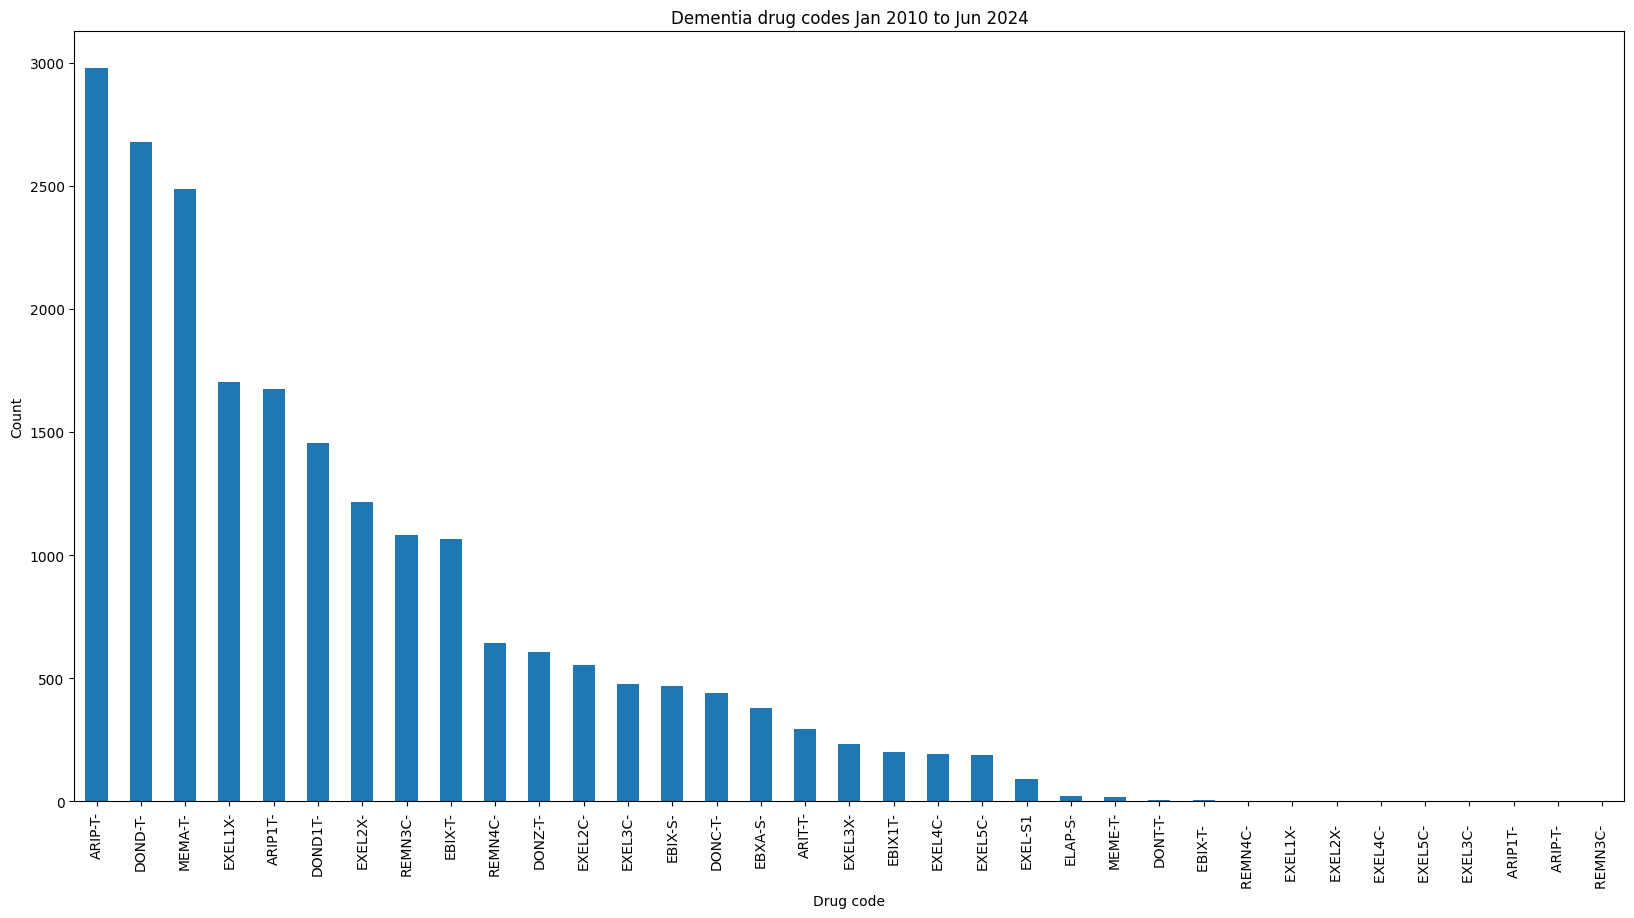

In [6]:
med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].value_counts().plot(kind='bar', figsize=(20, 10), title='Dementia drug codes Jan 2010 to Jun 2024', xlabel='Drug code', ylabel='Count')

In [7]:
std_ = pd.read_excel(DEMENTIA_STANDARD, 1)
std_dict = dict(zip(std_['drug_code'], std_['drug_name']))
std_dict = dict(zip(std_dict.keys(), [x.split()[0] for x in std_dict.values()]))
std_dict

{'ARIP-T-': 'Donepezil',
 'ARIP1T-': 'Donepezil',
 'ARIT-T-': 'Donepezil',
 'DONC-T-': 'Donepezil',
 'DOND-T-': 'Donepezil',
 'DOND1T-': 'Donepezil',
 'DONT-T-': 'Donepezil',
 'DONZ-T-': 'Donepezil',
 'EBIX-S-': 'Memantine',
 'EBIX-T-': 'Memantine',
 'EBIX1T-': 'Memantine',
 'EBXA-S-': 'Memantine',
 'ELAP-S-': 'Rivastigmine',
 'EXEL-S-': 'Rivastigmine',
 'EXEL-S1': 'Rivastigmine',
 'EXEL1C-': 'Rivastigmine',
 'EXEL1X-': 'Rivastigmine',
 'EXEL2C-': 'Rivastigmine',
 'EXEL2X-': 'Rivastigmine',
 'EXEL3C-': 'Rivastigmine',
 'EXEL3X-': 'Rivastigmine',
 'EXEL4C-': 'Rivastigmine',
 'EXEL5C-': 'Rivastigmine',
 'MEMA-T-': 'Memantine',
 'MEME-T-': 'Memantine',
 'REMN1T-': 'Galantamine',
 'REMN2T-': 'Galantamine',
 'REMN3C-': 'Galantamine',
 'REMN4C-': 'Galantamine'}

In [8]:
std_cnt = med.select('ENC_HN', 'D033KEY').unique().with_columns(pl.col('D033KEY').replace(std_dict)).group_by('D033KEY').agg(pl.col('ENC_HN').count()).sort('ENC_HN')
std_cnt

D033KEY,ENC_HN
str,u32
"""REMN3C- """,1
"""EXEL4C- """,1
"""ARIP-T- """,1
"""EXEL2X- """,1
"""EXEL5C- """,1
"""EXEL3C- """,1
"""ARIP1T- """,1
"""EXEL1X- """,2
"""REMN4C- """,2


<Axes: title={'center': 'Dementia drugs from Jan 2010 to Jun 2024'}, xlabel='Drug name', ylabel='Count'>

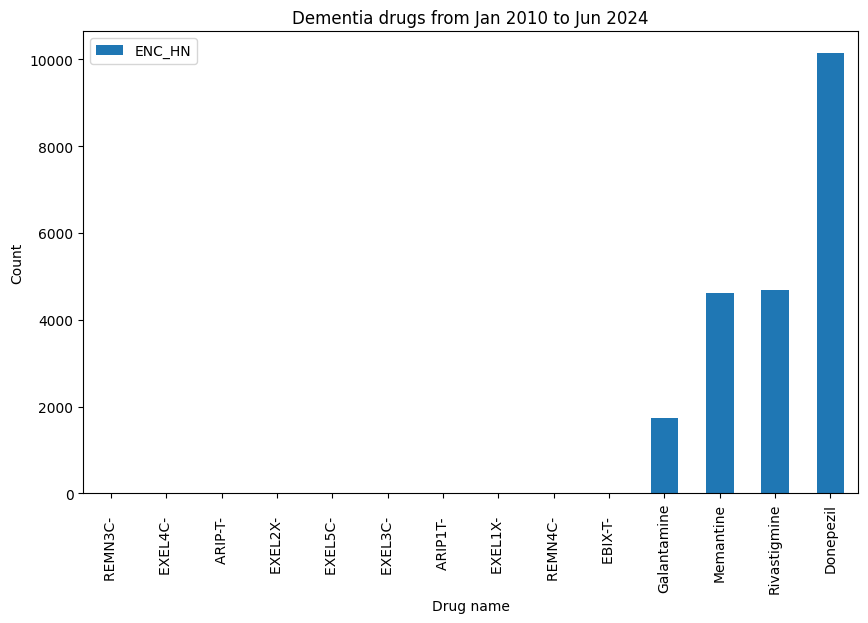

In [9]:
std_cnt.to_pandas().set_index('D033KEY').plot(kind='bar', figsize=(10, 6), title='Dementia drugs from Jan 2010 to Jun 2024', xlabel='Drug name', ylabel='Count')

In [10]:
unq = med.select('ENC_HN', 'D033KEY').unique().with_columns(pl.col('D033KEY').replace(std_dict)).group_by('D033KEY').agg(pl.col('ENC_HN').n_unique()).sort('ENC_HN')
unq

D033KEY,ENC_HN
str,u32
"""ARIP-T- """,1
"""REMN3C- """,1
"""EXEL3C- """,1
"""EXEL5C- """,1
"""ARIP1T- """,1
"""EXEL4C- """,1
"""EXEL2X- """,1
"""REMN4C- """,2
"""EXEL1X- """,2


<Axes: title={'center': 'Dementia drugs from Jan 2010 to Jun 2024'}, xlabel='Drug name', ylabel='Count'>

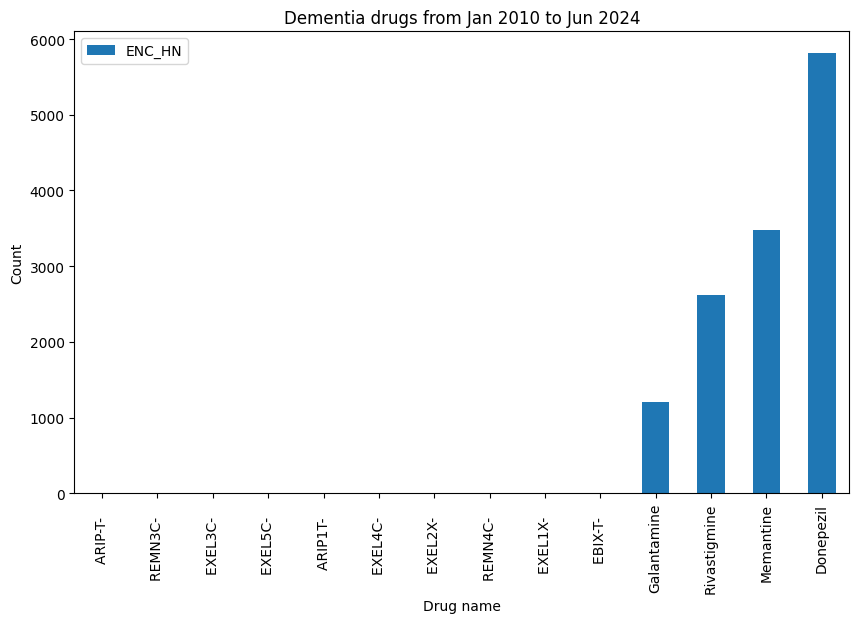

In [11]:
unq.to_pandas().set_index('D033KEY').plot(kind='bar', figsize=(10, 6), title='Dementia drugs from Jan 2010 to Jun 2024', xlabel='Drug name', ylabel='Count')

In [12]:
dx_paths = list(FOLDER_OC.dx.iterdir()) + list(FOLDER_NC.dx.iterdir())

dx = get_dx(dx_paths, re=dementia_icd_re, streaming=False)
dx

ENC_HN,D001KEY,D035KEY
str,date,str
"""AC7212FA9DF96F…",2010-11-10,"""G309"""
"""56B2B7210489B7…",2010-03-23,"""F0190"""
"""93B8C159EAD5D1…",2010-09-27,"""F0100"""
"""A9D4EE0C50ABC8…",2010-10-09,"""F0094, G309"""
"""83B797FA0FF72C…",2010-11-23,"""G309"""
"""1C72C94DD2CFE3…",2010-11-30,"""G309"""
"""3108A2780B6AC0…",2010-06-08,"""G309"""
"""FFB7B2457FD073…",2010-11-18,"""F0090, G309"""
"""B3AEEB90BCB0E7…",2010-04-23,"""G309"""


In [13]:
dx['ENC_HN'].n_unique()

7931

In [14]:
def get_dx_viz(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        file = file.with_columns(pl.col('D035KEY').str.slice(0, 4).str.replace('G318', 'G3183'))
        # One day per row
        # file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()

dx_viz = get_dx_viz(dx_paths, re=dementia_icd_re, streaming=False)
dx_viz

ENC_HN,D001KEY,D035KEY
str,date,str
"""5A52A0AAC357C5…",2010-11-16,"""F019"""
"""CA4BCADCE147C3…",2010-09-26,"""F009"""
"""299C0ABD71B230…",2010-11-05,"""G309"""
"""1E2A9386857CBC…",2010-12-20,"""F019"""
"""98E910C34AF306…",2010-11-16,"""F019"""
"""474DE888C89E8C…",2010-08-17,"""F009"""
"""A75A3558743931…",2010-10-14,"""F019"""
"""B6C121AF5E8E92…",2010-02-22,"""G309"""
"""56DBE3D6BEAD2F…",2010-12-14,"""F009"""


<Axes: title={'center': 'Dementia ICD10 codes Jan 2010 to Jun 2024'}, xlabel='ICD10 code', ylabel='Count'>

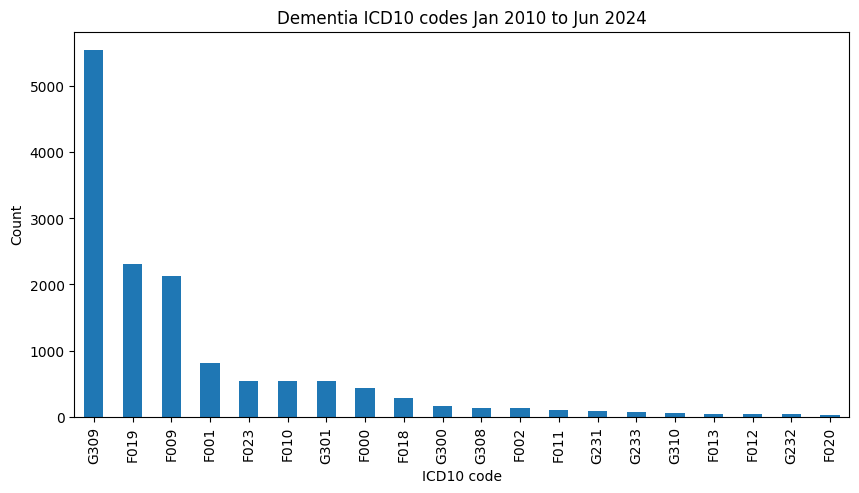

In [15]:
dx_viz.select('ENC_HN', 'D035KEY').unique().to_pandas()['D035KEY'].value_counts().plot(kind='bar', figsize=(10, 5), title='Dementia ICD10 codes Jan 2010 to Jun 2024', xlabel='ICD10 code', ylabel='Count')

In [16]:
dx_viz.select('ENC_HN', 'D035KEY').unique().to_pandas()['D035KEY'].value_counts()

D035KEY
G309    5548
F019    2312
F009    2132
F001     808
F023     542
G301     534
F010     534
F000     433
F018     275
G300     167
G308     126
F002     124
F011     102
G231      92
G233      62
G310      53
F013      44
F012      35
G232      33
F020      30
Name: count, dtype: int64

In [17]:
def add_bool(df):
    return df.with_columns(
        pl.col('D035KEY').is_not_null().alias('ICD_exists'),
        pl.col('D033KEY').is_not_null().alias('Med_exists'),
        (pl.col('D035KEY').is_not_null() & pl.col('D033KEY').is_not_null()).alias('Both_exists'),
    )

In [18]:
combined = dx.join(med, on=['ENC_HN', 'D001KEY'], how='outer_coalesce',)
combined = add_bool(combined)


In [19]:
n_hn = combined['ENC_HN'].n_unique()
n_hn

11795

In [20]:
# combined.write_csv(FOLDER_OUT / f'dementia_full_n={n_hn}_Jun2024.csv')

In [21]:
combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,7931,9166,4298


In [22]:
details = combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    # pl.max('Both_exists').alias('Both_exists'),
).with_columns(
    (pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('ICD_only'),
    (~pl.col('ICD_exists') & pl.col('Med_exists')).alias('Med_only'),
    (~pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('Neither'),
    (pl.col('ICD_exists') & pl.col('Med_exists')).alias('Both'),
)
details

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
str,bool,bool,bool,bool,bool,bool
"""80C1A5CC191DA0…",false,true,false,true,false,false
"""45E071798FE4E4…",false,true,false,true,false,false
"""1B51E6F150E743…",true,true,false,false,false,true
"""7BE6AAAB170E00…",true,true,false,false,false,true
"""4FBE5F62645526…",true,false,true,false,false,false
"""55C5C520792561…",false,true,false,true,false,false
"""3023AB10AE64DB…",true,true,false,false,false,true
"""A2118C3DDC05D4…",false,true,false,true,false,false
"""7DC9ED5B957A25…",false,true,false,true,false,false


In [23]:
details.sum()

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
str,u32,u32,u32,u32,u32,u32
null,7931,9166,2629,3864,0,5302


In [24]:
combined

ENC_HN,D001KEY,D035KEY,D033KEY,M1022,ICD_exists,Med_exists,Both_exists
str,date,str,str,str,bool,bool,bool
"""A434FAA313ACDC…",2024-03-21,"""F0090, F0190, …","""DOND-T-""","""63""",true,true,true
"""14C3ED7D22CF93…",2024-03-12,null,"""DOND-T-""","""67.05263157894…",false,true,false
"""14C3ED7D22CF93…",2024-03-12,null,"""DOND-T-""","""23.94736842105…",false,true,false
"""4E337FACB0A17F…",2024-03-25,"""G309""","""DOND-T-""","""82.52631578947…",true,true,true
"""1B3757D7B6ABFD…",2024-03-19,"""G309""","""DOND-T-""","""47.89473684210…",true,true,true
"""1B3757D7B6ABFD…",2024-03-19,"""G309""","""DOND-T-""","""134.1052631578…",true,true,true
"""C5BD973290120F…",2024-03-19,null,"""DOND-T-""","""91""",false,true,false
"""BFF8D4D64D528D…",2024-03-28,null,"""DOND-T-""","""9.210526315789…",false,true,false
"""BFF8D4D64D528D…",2024-03-18,null,"""DOND-T-""","""0.736842105263…",false,true,false


In [25]:
details.null_count()

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [26]:
(
    combined
    .filter(
        pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
            )
    .filter(pl.col('D035KEY').str.contains('G310|F020|F023'))
    ['ENC_HN'].n_unique()
)

220

In [27]:
(
    combined
    .filter(
        pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
            )
    .filter(~pl.col('D035KEY').str.contains('G310|F020|F023'))
    ['ENC_HN'].n_unique()
)

2475

In [28]:
details_v2 = combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    # pl.max('Both_exists').alias('Both_exists'),
).with_columns(
    (pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('ICD_only'),
    (~pl.col('ICD_exists') & pl.col('Med_exists')).alias('Med_only'),
    (~pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('Neither'),
    (pl.col('ICD_exists') & pl.col('Med_exists')).alias('Both'),
)
details

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
str,bool,bool,bool,bool,bool,bool
"""80C1A5CC191DA0…",false,true,false,true,false,false
"""45E071798FE4E4…",false,true,false,true,false,false
"""1B51E6F150E743…",true,true,false,false,false,true
"""7BE6AAAB170E00…",true,true,false,false,false,true
"""4FBE5F62645526…",true,false,true,false,false,false
"""55C5C520792561…",false,true,false,true,false,false
"""3023AB10AE64DB…",true,true,false,false,false,true
"""A2118C3DDC05D4…",false,true,false,true,false,false
"""7DC9ED5B957A25…",false,true,false,true,false,false


In [46]:
icdonlyhn = details.filter(pl.col('ICD_only')).to_series().to_list()
print(len(icdonlyhn))
dist = dx.filter(pl.col('ENC_HN').is_in(icdonlyhn)).group_by('D035KEY').agg(pl.col('ENC_HN').count()).sort('ENC_HN', descending=True)
dist.head(20)

2629


D035KEY,ENC_HN
str,u32
"""G309""",3842
"""F0190""",1375
"""F0194""",524
"""F0094""",299
"""F0230""",256
"""G231""",215
"""F0090""",211
"""G233""",189
"""F0010""",170


<Axes: xlabel='D035KEY'>

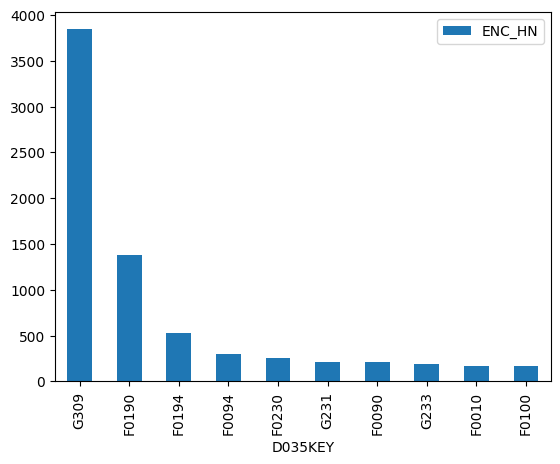

In [52]:
dist.to_pandas()[:10].set_index('D035KEY').plot(kind='bar')

In [ ]:
# (
#     combined
#     .filter(
#         pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
#             )
#     .select('ENC_HN')
#     .unique()
# ).write_csv(FOLDER_OUT / 'specific/dementia_ICD_only_2631_for_MRI.csv')

In [ ]:
# details.write_csv(FOLDER_OUT / 'specific' / f'dementia_details_{n_hn}_Jun2024.csv')

In [ ]:
# details = pl.read_csv(FOLDER_OUT / 'specific' / f'dementia_details_{n_hn}_Jun2024.csv')
# icd_sample = details.filter(pl.col('ICD_only')).sample(1000, seed=42)
# icd_sample

In [ ]:
# dx.filter(pl.col('ENC_HN').is_in(icd_sample['ENC_HN'])).select('D035KEY').to_series().value_counts().sort('D035KEY')

In [ ]:
# icd_sample[['ENC_HN']].write_csv(FOLDER_OUT / 'specific' / 'dementia_icd_only_sample1000_Jun2024.csv')

In [ ]:
# sample_real = icd_sample[['ENC_HN']].join(pl.read_excel(r'D:\Prut\Warehouses\output\Jun24\n\dementia\specific\HN-dementia-ICD10-only-4-9-2024-with-Hashed.xlsx'), on='ENC_HN', how='left')
# sample_real

In [ ]:
# sample_real.write_csv(FOLDER_OUT / 'specific' / 'dementia_icd_only_sample1000_Jun2024_with_hashed.csv')